# Jupyter notebook analyzing synaptic properties of GluA1, GluA4, Stg, PSD95, and NR1 in 2023.10 Stg KO Ctx dataset

Last edited by MES on 10/18/24 (just to add group value counts)

In [1]:
#import relevant packages
import os
import numpy as np
#from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
import scanpy as sc
import anndata
#import leidenalg
#import igraph as ig
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy import stats
import scipy.io as sio

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def unique(list1): 
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set))
    return unique_list

In [4]:
parentdir = '/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/2023.10_StgKO/'

In [5]:
filenames = os.listdir(parentdir)
csvs = [filename for filename in filenames if filename.endswith('csv')]

In [6]:
csvs

['StgKO_synaptic_protein_quantification_v1_tidytable.csv',
 'trn_synapse_data_combined.csv',
 'ctx_synapse_data_combined.csv',
 'ctx_KOvsCtrl_selectedsynapses_lmer_pvals.csv',
 'TRN_group1vs2_lmer_pvals.csv',
 'trn_KOvsCtrl_selectedsynapses_lmer_pvals.csv',
 'ctx_group1vs2_lmer_pvals.csv']

In [7]:
mats = [filename for filename in filenames if filename.endswith('mat')]

In [8]:
mats

['analyzed_data_trn_nofilt_20240908.mat',
 'analyzed_data_ctx_nofilt_20240907.mat',
 'analyzed_data_trn_nofilt_ztrim_20240913.mat',
 'analyzed_data_ctx_nofilt_ztrim_20240912.mat']

In [9]:
matfile = sio.loadmat('analyzed_data_ctx_nofilt_ztrim_20240912.mat',squeeze_me=True)

In [10]:
sorted(matfile.keys())

['__globals__', '__header__', '__version__', 'data']

In [11]:
matdata = matfile['data']

In [12]:
matdata

array((array(['mouseA-ROI1-2_NR1_syn1', 'mouseA-ROI1-2_NR1_syn2',
       'mouseA-ROI1-2_NR1_syn3', ..., 'mouseG-ROI5_NR1_syn1313',
       'mouseG-ROI5_NR1_syn1314', 'mouseG-ROI5_NR1_syn1315'], dtype=object), array([[4.95001040e-05, 4.16525265e-04, 1.43429570e-03, 3.98415471e-05,
        9.90002080e-05, 1.55744230e-04],
       [0.00000000e+00, 1.20731961e-04, 6.27806197e-05, 7.00245374e-05,
        0.00000000e+00, 1.09866084e-04],
       [0.00000000e+00, 7.24391766e-06, 1.09866084e-04, 2.17317530e-05,
        9.29636099e-05, 7.24391766e-06],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.03659805e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.17562903e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08658765e-05,
        1.11073404e-04, 0.00000000e+00]]), array([[  7.80487805,   7.71884058, 104.31565657,   9.24242424,
          9.29268293,   6.79069767],

In [13]:
names = matdata['names'].item().tolist()

In [14]:
vols = matdata['total_vol'].item()

In [15]:
ints = matdata['mean_int'].item()

In [16]:
ns = matdata['npuncta'].item()

In [17]:
ints_refnorm = matdata['mean_int_refnorm'].item()

In [18]:
selected_tfs = matdata['selected_tf'].item()

In [19]:
data_array = np.concatenate((vols,ints,ints_refnorm), axis=1)

In [20]:
data_array.shape

(36941, 18)

In [21]:
#protein order: GluA4, Stg, GluA1, PSD95, GluA3, NR1

In [22]:
data = pd.DataFrame(data_array,index=names,
                    columns=['GluA4_vol','Stg_vol','GluA1_vol','PSD95_vol','GluA3_vol','NR1_vol',
                            'GluA4_meanint','Stg_meanint','GluA1_meanint','PSD95_meanint','GluA3_meanint','NR1_meanint',
                             'GluA4_meanint_refnorm','Stg_meanint_refnorm','GluA1_meanint_refnorm','PSD95_meanint_refnorm','GluA3_meanint_refnorm','NR1_meanint_refnorm',
                            ])

In [23]:
data.tail(10)

,GluA4_vol,Stg_vol,GluA1_vol,PSD95_vol,GluA3_vol,NR1_vol,GluA4_meanint,Stg_meanint,GluA1_meanint,PSD95_meanint,GluA3_meanint,NR1_meanint,GluA4_meanint_refnorm,Stg_meanint_refnorm,GluA1_meanint_refnorm,PSD95_meanint_refnorm,GluA3_meanint_refnorm,NR1_meanint_refnorm
mouseG-ROI5_NR1_syn1306,0.0,0.000006,0.000124,0.000021,0.000001,0.00011,0.0,8.600000,158.708738,8.647059,9.000000,6.615385,0.0,0.097950,37.236902,0.334852,0.020501,1.371298
mouseG-ROI5_NR1_syn1307,0.0,0.000045,0.000030,0.000000,0.000042,0.00000,0.0,6.486486,21.480000,0.000000,14.942857,0.000000,0.0,0.546697,1.223235,0.000000,1.191344,0.000000
mouseG-ROI5_NR1_syn1308,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
mouseG-ROI5_NR1_syn1309,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
mouseG-ROI5_NR1_syn1310,0.0,0.000000,0.000033,0.000000,0.000013,0.00000,0.0,0.000000,18.666667,0.000000,15.090909,0.000000,0.0,0.000000,1.148064,0.000000,0.378132,0.000000
mouseG-ROI5_NR1_syn1311,0.0,0.000000,0.000104,0.000000,0.000002,0.00000,0.0,0.000000,24.662791,0.000000,14.000000,0.000000,0.0,0.000000,4.831435,0.000000,0.063781,0.000000
mouseG-ROI5_NR1_syn1312,0.0,0.000000,0.000000,0.000013,0.000045,0.00000,0.0,0.000000,0.000000,8.000000,9.486486,0.000000,0.0,0.000000,0.000000,0.200456,0.799544,0.000000
mouseG-ROI5_NR1_syn1313,0.0,0.000000,0.000000,0.000000,0.000006,0.00000,0.0,0.000000,0.000000,0.000000,35.800000,0.000000,0.0,0.000000,0.000000,0.000000,0.407745,0.000000
mouseG-ROI5_NR1_syn1314,0.0,0.000000,0.000092,0.000000,0.000000,0.00000,0.0,0.000000,19.947368,0.000000,0.000000,0.000000,0.0,0.000000,3.453303,0.000000,0.000000,0.000000
mouseG-ROI5_NR1_syn1315,0.0,0.000000,0.000000,0.000011,0.000111,0.00000,0.0,0.000000,0.000000,9.111111,26.467391,0.000000,0.0,0.000000,0.000000,0.186788,5.546697,0.000000


In [24]:
data.shape

(36941, 18)

In [25]:
data.head(5)

,GluA4_vol,Stg_vol,GluA1_vol,PSD95_vol,GluA3_vol,NR1_vol,GluA4_meanint,Stg_meanint,GluA1_meanint,PSD95_meanint,GluA3_meanint,NR1_meanint,GluA4_meanint_refnorm,Stg_meanint_refnorm,GluA1_meanint_refnorm,PSD95_meanint_refnorm,GluA3_meanint_refnorm,NR1_meanint_refnorm
mouseA-ROI1-2_NR1_syn1,0.00005,0.000417,0.001434,0.000040,0.000099,0.000156,7.804878,7.718841,104.315657,9.242424,9.292683,6.790698,0.054072,8.731148,406.318033,1.000000,2.498361,2.872131
mouseA-ROI1-2_NR1_syn2,0.00000,0.000121,0.000063,0.000070,0.000000,0.000110,0.000000,6.140000,159.307692,37.879310,0.000000,9.901099,0.000000,2.013115,27.160656,7.203279,0.000000,2.954098
mouseA-ROI1-2_NR1_syn3,0.00000,0.000007,0.000110,0.000022,0.000093,0.000007,0.000000,4.500000,139.516484,17.888889,10.857143,5.666667,0.000000,0.088525,41.626230,1.055738,2.740984,0.111475
mouseA-ROI1-2_NR1_syn4,0.00000,0.000135,0.000112,0.000103,0.000326,0.000270,0.000000,6.196429,257.301075,35.988235,14.214815,10.495536,0.000000,2.275410,78.455738,10.029508,12.583607,7.708197
mouseA-ROI1-2_NR1_syn5,0.00000,0.000000,0.000109,0.000088,0.000000,0.000634,0.000000,0.000000,80.044444,13.164384,0.000000,8.956190,0.000000,0.000000,23.619672,3.150820,0.000000,15.416393


In [26]:
data['selected_tf'] = selected_tfs

In [27]:
#How many synapses were selected?
data['selected_tf'].value_counts()

selected_tf
0    36420
1      521
Name: count, dtype: int64

## 1. Add metadata

In [28]:
groupdict = {
    'A':'Ctrl',
    'B':'Ctrl',
    'D':'Ctrl',
    'E':'KO',
    'F':'KO',
    'G':'KO'
}

In [29]:
data.head(3)

,GluA4_vol,Stg_vol,GluA1_vol,PSD95_vol,GluA3_vol,NR1_vol,GluA4_meanint,Stg_meanint,GluA1_meanint,PSD95_meanint,GluA3_meanint,NR1_meanint,GluA4_meanint_refnorm,Stg_meanint_refnorm,GluA1_meanint_refnorm,PSD95_meanint_refnorm,GluA3_meanint_refnorm,NR1_meanint_refnorm,selected_tf
mouseA-ROI1-2_NR1_syn1,0.00005,0.000417,0.001434,0.000040,0.000099,0.000156,7.804878,7.718841,104.315657,9.242424,9.292683,6.790698,0.054072,8.731148,406.318033,1.000000,2.498361,2.872131,0
mouseA-ROI1-2_NR1_syn2,0.00000,0.000121,0.000063,0.000070,0.000000,0.000110,0.000000,6.140000,159.307692,37.879310,0.000000,9.901099,0.000000,2.013115,27.160656,7.203279,0.000000,2.954098,0
mouseA-ROI1-2_NR1_syn3,0.00000,0.000007,0.000110,0.000022,0.000093,0.000007,0.000000,4.500000,139.516484,17.888889,10.857143,5.666667,0.000000,0.088525,41.626230,1.055738,2.740984,0.111475,0


In [30]:
samples = []
fovs = [] 
syns = []
groups = []

for idx,row in data.iterrows():
    splits = idx.split("_")
    splits2 = splits[0].split("-")

    sample = splits2[0]

    if len(splits2) > 2:
        fov = splits2[1] + '-' + splits2[2]
    else:
        fov = splits2[1]
    
    syn = splits[2]
    group = groupdict[sample[-1]]
    
    samples.append(sample)
    fovs.append(fov)
    syns.append(syn)
    groups.append(group)

In [31]:
unique(samples)

['mouseA', 'mouseB', 'mouseE', 'mouseD', 'mouseG', 'mouseF']

In [32]:
unique(fovs)

['ROI4-2',
 'ROI4-1',
 'ROI3-1',
 'ROI3-2',
 'ROI2',
 'ROI3',
 'ROI1',
 'ROI1-2',
 'ROI1-3',
 'ROI4',
 'ROI5']

In [33]:
data['sample'] = samples
data['fov'] = fovs
data['syn'] = syns
data['group'] = groups

In [34]:
data.shape

(36941, 23)

In [35]:
selected_yns = []
for idx,row in data.iterrows():
    if row['selected_tf']:
        selected_yns.append('selected')
    else:
        selected_yns.append('unselected')

In [36]:
data['selected_group']=selected_yns

In [37]:
data.head(5)

,GluA4_vol,Stg_vol,GluA1_vol,PSD95_vol,GluA3_vol,NR1_vol,GluA4_meanint,Stg_meanint,GluA1_meanint,PSD95_meanint,...,GluA1_meanint_refnorm,PSD95_meanint_refnorm,GluA3_meanint_refnorm,NR1_meanint_refnorm,selected_tf,sample,fov,syn,group,selected_group
mouseA-ROI1-2_NR1_syn1,0.00005,0.000417,0.001434,0.000040,0.000099,0.000156,7.804878,7.718841,104.315657,9.242424,...,406.318033,1.000000,2.498361,2.872131,0,mouseA,ROI1-2,syn1,Ctrl,unselected
mouseA-ROI1-2_NR1_syn2,0.00000,0.000121,0.000063,0.000070,0.000000,0.000110,0.000000,6.140000,159.307692,37.879310,...,27.160656,7.203279,0.000000,2.954098,0,mouseA,ROI1-2,syn2,Ctrl,unselected
mouseA-ROI1-2_NR1_syn3,0.00000,0.000007,0.000110,0.000022,0.000093,0.000007,0.000000,4.500000,139.516484,17.888889,...,41.626230,1.055738,2.740984,0.111475,0,mouseA,ROI1-2,syn3,Ctrl,unselected
mouseA-ROI1-2_NR1_syn4,0.00000,0.000135,0.000112,0.000103,0.000326,0.000270,0.000000,6.196429,257.301075,35.988235,...,78.455738,10.029508,12.583607,7.708197,0,mouseA,ROI1-2,syn4,Ctrl,unselected
mouseA-ROI1-2_NR1_syn5,0.00000,0.000000,0.000109,0.000088,0.000000,0.000634,0.000000,0.000000,80.044444,13.164384,...,23.619672,3.150820,0.000000,15.416393,0,mouseA,ROI1-2,syn5,Ctrl,unselected


In [38]:
data.to_csv(parentdir + 'ctx_synapse_data_combined.csv')

## Examine distribution of volumes of each protein in selected synapses in KO vs. Ctrl

In [39]:
data = data[data['selected_group']=='selected']

In [40]:
data.shape

(521, 24)

In [41]:
data['group'].value_counts()

group
Ctrl    314
KO      207
Name: count, dtype: int64

In [43]:
data['sample'].value_counts()

sample
mouseA    120
mouseB    107
mouseG     97
mouseD     87
mouseE     71
mouseF     39
Name: count, dtype: int64

### 1. GluA4

<Axes: xlabel='GluA4_vol', ylabel='Count'>

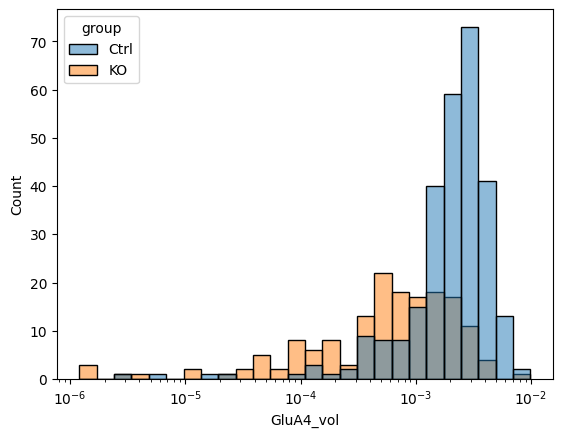

In [41]:
sns.histplot(data, x='GluA4_vol', hue='group',log_scale=True)

<Axes: ylabel='GluA4_vol'>

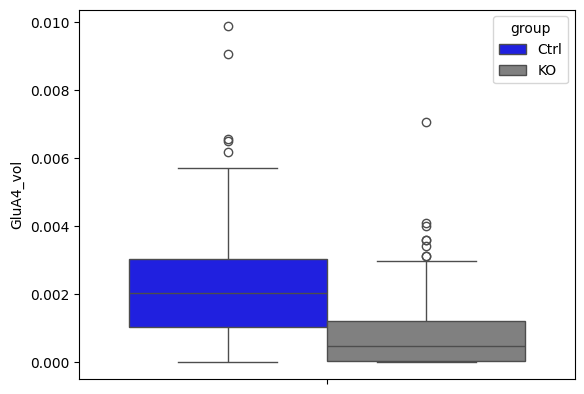

In [42]:
sns.boxplot(data, y="GluA4_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='GluA4_meanint_refnorm'>

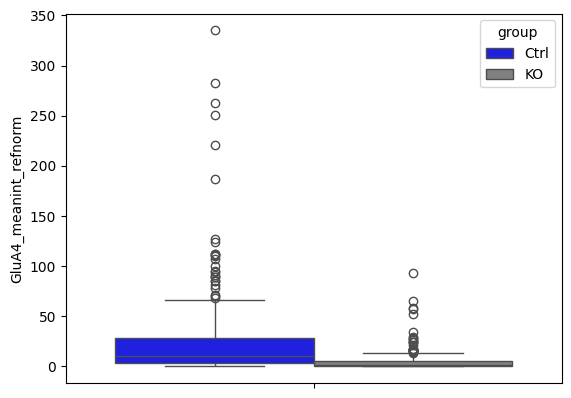

In [43]:
sns.boxplot(data, y="GluA4_meanint_refnorm", hue="group",palette=['blue','gray'])

### 2. Stg

<Axes: xlabel='Stg_vol', ylabel='Count'>

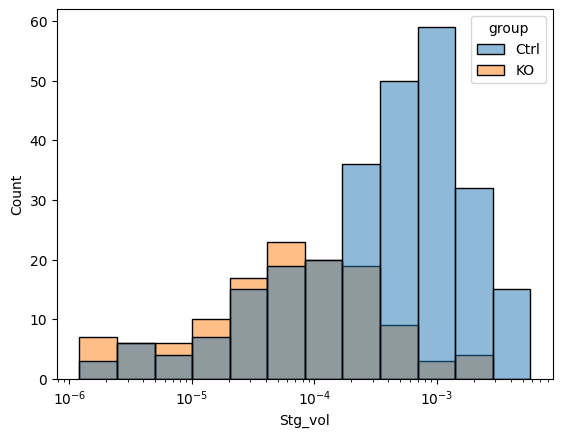

In [44]:
sns.histplot(data, x='Stg_vol', hue='group',log_scale=True)

<Axes: ylabel='Stg_vol'>

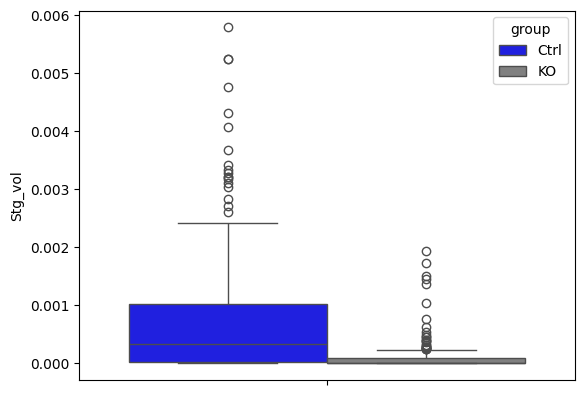

In [45]:
sns.boxplot(data, y="Stg_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='Stg_meanint_refnorm'>

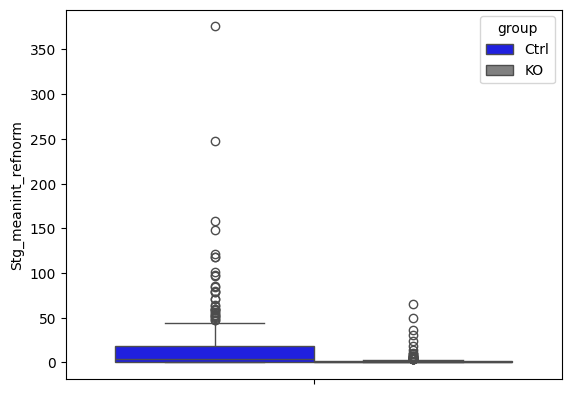

In [46]:
sns.boxplot(data, y="Stg_meanint_refnorm", hue="group",palette=['blue','gray'])

### 3. GluA1

<Axes: xlabel='GluA1_vol', ylabel='Count'>

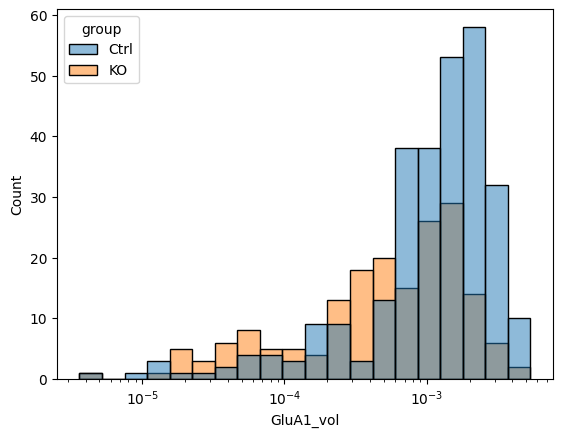

In [47]:
sns.histplot(data, x='GluA1_vol', hue='group',log_scale=True)

<Axes: ylabel='GluA1_vol'>

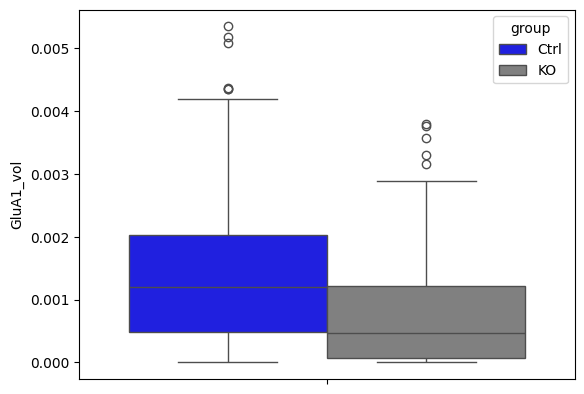

In [48]:
sns.boxplot(data, y="GluA1_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='GluA1_meanint_refnorm'>

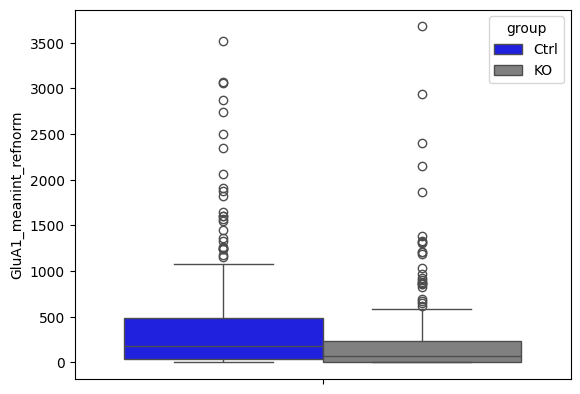

In [49]:
sns.boxplot(data, y="GluA1_meanint_refnorm", hue="group",palette=['blue','gray'])

### 4. PSD95

<Axes: xlabel='PSD95_vol', ylabel='Count'>

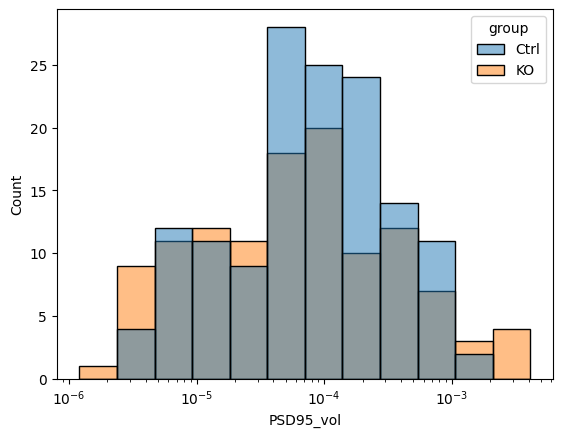

In [50]:
sns.histplot(data, x='PSD95_vol', hue='group',log_scale=True)

<Axes: ylabel='PSD95_vol'>

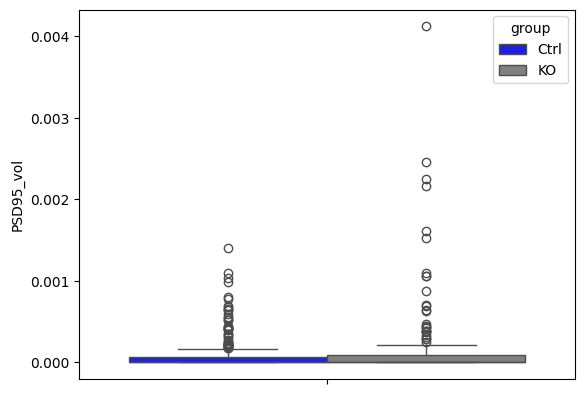

In [51]:
sns.boxplot(data, y="PSD95_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='PSD95_meanint_refnorm'>

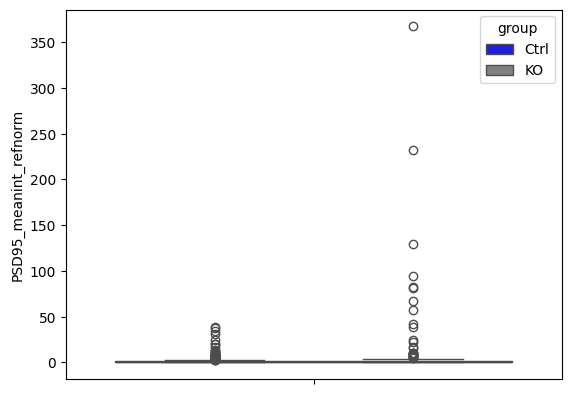

In [52]:
sns.boxplot(data, y="PSD95_meanint_refnorm", hue="group",palette=['blue','gray'])

### 5. GluA3

<Axes: xlabel='GluA3_vol', ylabel='Count'>

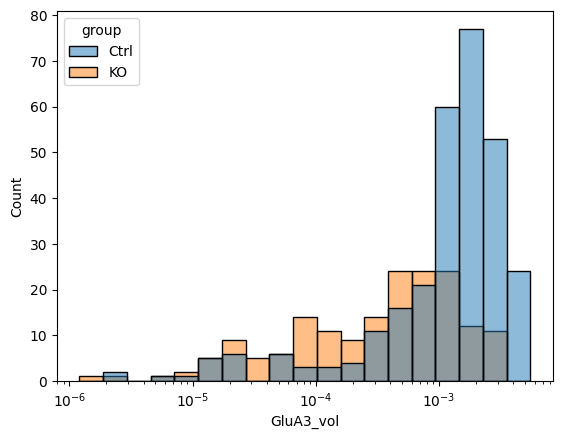

In [53]:
sns.histplot(data, x='GluA3_vol', hue='group',log_scale=True)

<Axes: ylabel='GluA3_vol'>

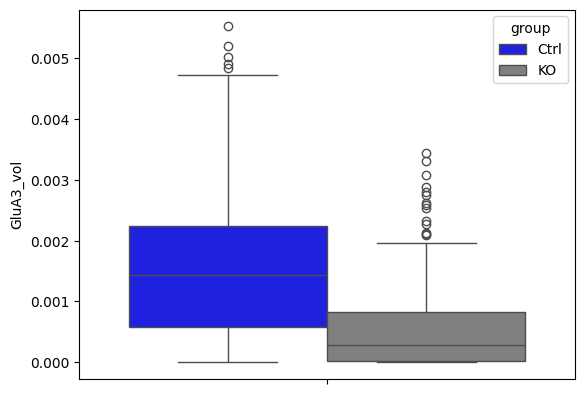

In [54]:
sns.boxplot(data, y="GluA3_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='GluA3_meanint_refnorm'>

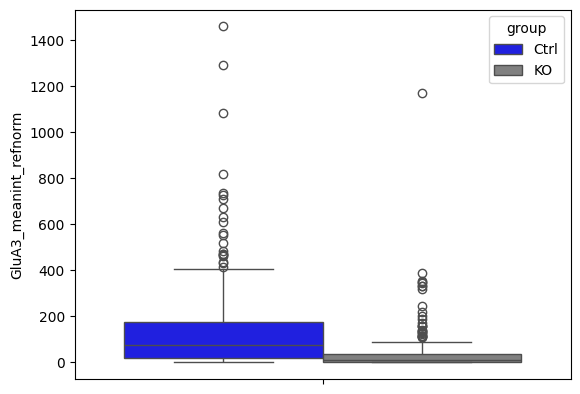

In [55]:
sns.boxplot(data, y="GluA3_meanint_refnorm", hue="group",palette=['blue','gray'])

### 6. NR1

<Axes: xlabel='NR1_vol', ylabel='Count'>

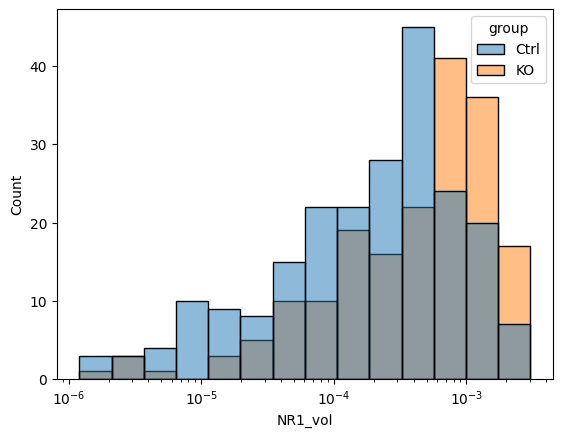

In [56]:
sns.histplot(data, x='NR1_vol', hue='group',log_scale=True)

<Axes: ylabel='NR1_vol'>

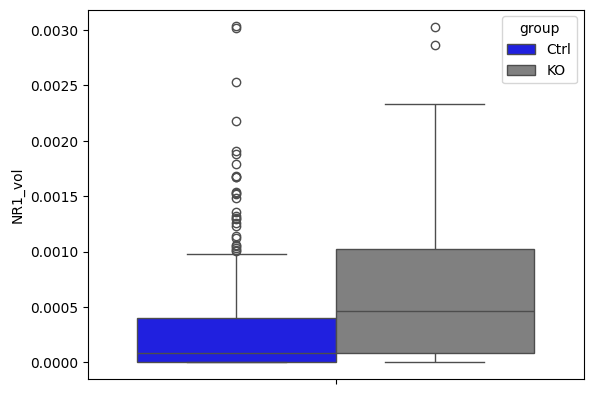

In [57]:
sns.boxplot(data, y="NR1_vol", hue="group",palette=['blue','gray'])

<Axes: ylabel='NR1_meanint_refnorm'>

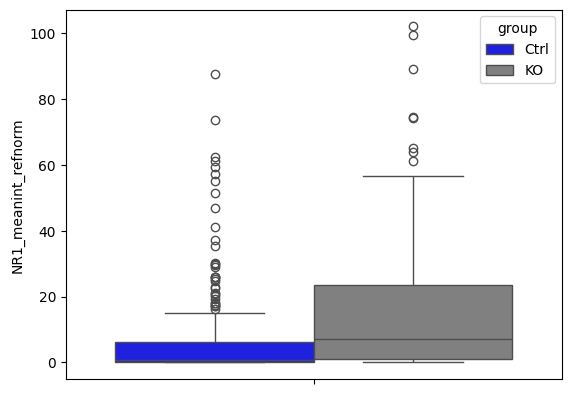

In [58]:
sns.boxplot(data, y="NR1_meanint_refnorm", hue="group",palette=['blue','gray'])

# Test for statistically significant differences in these properties between synapse types

In [59]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [60]:
list(data)

['GluA4_vol',
 'Stg_vol',
 'GluA1_vol',
 'PSD95_vol',
 'GluA3_vol',
 'NR1_vol',
 'GluA4_meanint',
 'Stg_meanint',
 'GluA1_meanint',
 'PSD95_meanint',
 'GluA3_meanint',
 'NR1_meanint',
 'GluA4_meanint_refnorm',
 'Stg_meanint_refnorm',
 'GluA1_meanint_refnorm',
 'PSD95_meanint_refnorm',
 'GluA3_meanint_refnorm',
 'NR1_meanint_refnorm',
 'selected_tf',
 'sample',
 'fov',
 'syn',
 'group',
 'selected_group']

In [61]:
#approximate new alpha?
0.05 / (6*4)

0.0020833333333333333

In [62]:
unadjusted_pvals = []
zscores = []

### 1. GluA4

In [63]:
# Run mixed lm for target
md = smf.mixedlm("GluA4_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA4_vol
No. Observations: 521     Method:             REML     
No. Groups:       11      Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     2687.9744
Max. group size:  104     Converged:          Yes      
Mean group size:  47.4                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.002    0.000 12.388 0.000  0.002  0.003
group[T.KO]  -0.001    0.000 -8.519 0.000 -0.001 -0.001
Group Var     0.000    0.000                           



In [64]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

3.032867737808788e-35
1.611903485822058e-17


In [65]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("GluA4_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA4_meanint_refnorm
No. Observations: 521     Method:             REML                 
No. Groups:       11      Scale:              970.0651             
Min. group size:  11      Log-Likelihood:     -2536.5354           
Max. group size:  104     Converged:          Yes                  
Mean group size:  47.4                                             
---------------------------------------------------------------------
                Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept       26.711      4.491    5.947   0.000    17.908   35.514
group[T.KO]    -12.898      3.090   -4.174   0.000   -18.956   -6.841
Group Var      179.166      3.170                                    



In [66]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.730058083317366e-09
2.997573174941753e-05


### 2. Stg

In [67]:
# Run mixed lm for target
md = smf.mixedlm("Stg_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Stg_vol  
No. Observations: 521     Method:             REML     
No. Groups:       11      Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     2982.2401
Max. group size:  104     Converged:          Yes      
Mean group size:  47.4                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.001    0.000  8.920 0.000  0.001  0.001
group[T.KO]  -0.000    0.000 -6.063 0.000 -0.001 -0.000
Group Var     0.000    0.000                           



In [68]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

4.665519594584972e-19
1.3374274880339124e-09


In [69]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("Stg_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Stg_meanint_refnorm
No. Observations: 521     Method:             REML               
No. Groups:       11      Scale:              694.4810           
Min. group size:  11      Log-Likelihood:     -2448.4337         
Max. group size:  104     Converged:          Yes                
Mean group size:  47.4                                           
-------------------------------------------------------------------
              Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     19.068      3.341    5.707   0.000    12.520   25.617
group[T.KO]   -9.741      2.651   -3.674   0.000   -14.937   -4.545
Group Var     91.134      2.115                                    



In [70]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.1501840366008205e-08
0.00023859233051350576


### 3. GluA1

In [71]:
# Run mixed lm for target
md = smf.mixedlm("GluA1_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA1_vol
No. Observations: 521     Method:             REML     
No. Groups:       11      Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     2853.2166
Max. group size:  104     Converged:          Yes      
Mean group size:  47.4                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.001    0.000 10.623 0.000  0.001  0.002
group[T.KO]  -0.000    0.000 -3.916 0.000 -0.001 -0.000
Group Var     0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [72]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.3246734589690416e-26
9.005530742680505e-05


In [73]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("GluA1_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA1_meanint_refnorm
No. Observations: 521     Method:             REML                 
No. Groups:       11      Scale:              269916.9869          
Min. group size:  11      Log-Likelihood:     -3993.7082           
Max. group size:  104     Converged:          Yes                  
Mean group size:  47.4                                             
--------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|   [0.025    0.975]
--------------------------------------------------------------------
Intercept        410.858    54.251   7.573  0.000   304.528  517.187
group[T.KO]     -113.511    51.243  -2.215  0.027  -213.946  -13.076
Group Var      20262.998    31.753                                  



In [74]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

3.6383540743679053e-14
0.026750129990220223


### 4. PSD95

In [75]:
# Run mixed lm for target
md = smf.mixedlm("PSD95_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PSD95_vol
No. Observations: 521     Method:             REML     
No. Groups:       11      Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     3437.4391
Max. group size:  104     Converged:          Yes      
Mean group size:  47.4                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.000    0.000 4.366 0.000  0.000  0.000
group[T.KO]    0.000    0.000 2.372 0.018  0.000  0.000
Group Var      0.000    0.000                          



In [76]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.2662733468148485e-05
0.017668678640304206


In [77]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("PSD95_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PSD95_meanint_refnorm
No. Observations: 521     Method:             REML                 
No. Groups:       11      Scale:              456.3683             
Min. group size:  11      Log-Likelihood:     -2332.4078           
Max. group size:  104     Converged:          Yes                  
Mean group size:  47.4                                             
----------------------------------------------------------------------
               Coef.    Std.Err.      z      P>|z|    [0.025    0.975]
----------------------------------------------------------------------
Intercept      1.823       1.362    1.338    0.181    -0.847     4.494
group[T.KO]    5.334       1.963    2.717    0.007     1.486     9.182
Group Var      3.742       0.221                                      



In [78]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.18079486413738388
0.006590491481795452


### 5. GluA3

In [79]:
# Run mixed lm for target
md = smf.mixedlm("GluA3_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA3_vol
No. Observations: 521     Method:             REML     
No. Groups:       11      Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     2822.2494
Max. group size:  104     Converged:          Yes      
Mean group size:  47.4                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.002    0.000 12.505 0.000  0.001  0.002
group[T.KO]  -0.001    0.000 -7.769 0.000 -0.001 -0.001
Group Var     0.000    0.000                           



In [80]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

7.022423000549722e-36
7.930565986422613e-15


In [81]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("GluA3_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GluA3_meanint_refnorm
No. Observations: 521     Method:             REML                 
No. Groups:       11      Scale:              24362.1382           
Min. group size:  11      Log-Likelihood:     -3370.7115           
Max. group size:  104     Converged:          Yes                  
Mean group size:  47.4                                             
--------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|   [0.025    0.975]
--------------------------------------------------------------------
Intercept        148.915    18.180   8.191  0.000   113.283  184.546
group[T.KO]      -70.231    15.774  -4.452  0.000  -101.148  -39.315
Group Var       2507.021    11.317                                  



In [82]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.584767362481074e-16
8.491142554299376e-06


### 6. Stg

In [83]:
# Run mixed lm for target
md = smf.mixedlm("NR1_vol ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: NR1_vol  
No. Observations: 521     Method:             REML     
No. Groups:       11      Scale:              0.0000   
Min. group size:  11      Log-Likelihood:     3154.0405
Max. group size:  104     Converged:          Yes      
Mean group size:  47.4                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.000    0.000 6.399 0.000  0.000  0.000
group[T.KO]    0.000    0.000 6.657 0.000  0.000  0.000
Group Var      0.000    0.000                          



In [84]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.5671153577841096e-10
2.7960971196991303e-11


In [85]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("NR1_meanint_refnorm ~ group", data, groups=data["fov"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: NR1_meanint_refnorm
No. Observations: 521     Method:             REML               
No. Groups:       11      Scale:              232.9620           
Min. group size:  11      Log-Likelihood:     -2160.3385         
Max. group size:  104     Converged:          Yes                
Mean group size:  47.4                                           
-------------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept        5.787      1.220   4.745   0.000    3.397    8.177
group[T.KO]      9.456      1.448   6.530   0.000    6.618   12.294
Group Var        7.280      0.367                                  



In [86]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.0852870634980456e-06
6.570905261747206e-11


#### Compile p-values

In [87]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
    'Stg_vol',
    'Stg_meanint_refnorm',
    'GluA1_vol',
    'GluA1_meanint_refnorm',
    'PSD95_vol',
    'PSD95_meanint_refnorm',
    'GluA3_vol',
    'GluA3_meanint_refnorm',
    'NR1_vol',
    'NR1_meanint_refnorm'
]

In [88]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [89]:
pvals_df['zscore_unselected'] = zscores

### Create bar plots for each of these measures

#### Adjust p-values

In [90]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv(parentdir + 'ctx_KOvsCtrl_selectedsynapses_lmer_pvals.csv')

In [91]:
prots = ['GluA4','Stg','GluA1','PSD95','GluA3','NR1']

In [92]:
values = ['vol','meanint_refnorm']

In [93]:
group_colors = ['blue','gray']

In [94]:
pvals_df

,p_unadjusted,zscore_unselected,p_adjusted,significant
GluA4_vol,1.611903e-17,-8.519,1.934284e-16,True
GluA4_meanint_refnorm,2.997573e-05,-4.174,5.138697e-05,True
Stg_vol,1.337427e-09,-6.063,3.209826e-09,True
Stg_meanint_refnorm,2.385923e-04,-3.674,3.181231e-04,True
GluA1_vol,9.005531e-05,-3.916,1.350830e-04,True
GluA1_meanint_refnorm,2.675013e-02,-2.215,2.675013e-02,True
PSD95_vol,1.766868e-02,2.372,1.927492e-02,True
PSD95_meanint_refnorm,6.590491e-03,2.717,7.908590e-03,True
GluA3_vol,7.930566e-15,-7.769,4.758340e-14,True
GluA3_meanint_refnorm,8.491143e-06,-4.452,1.698229e-05,True


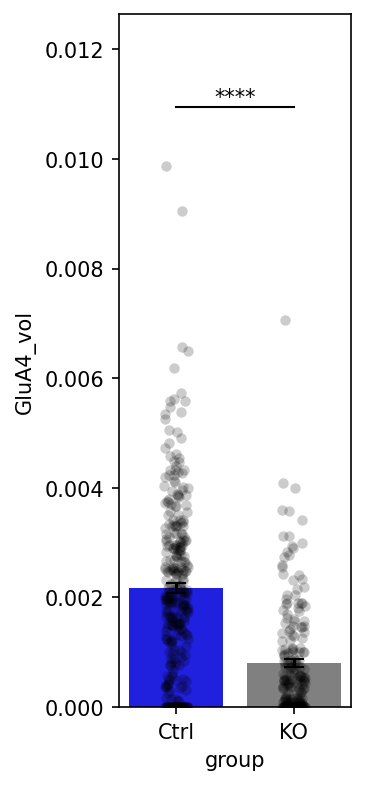

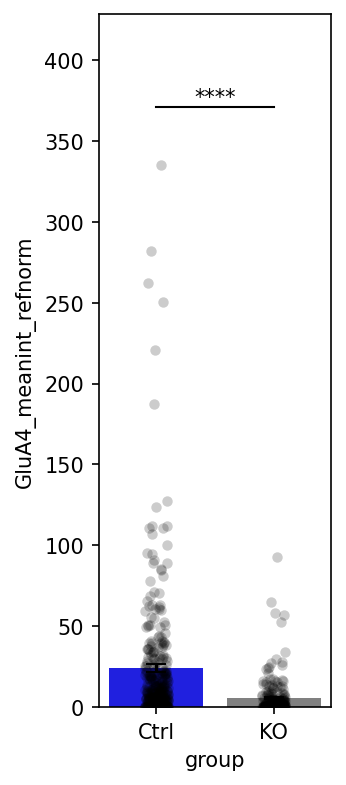

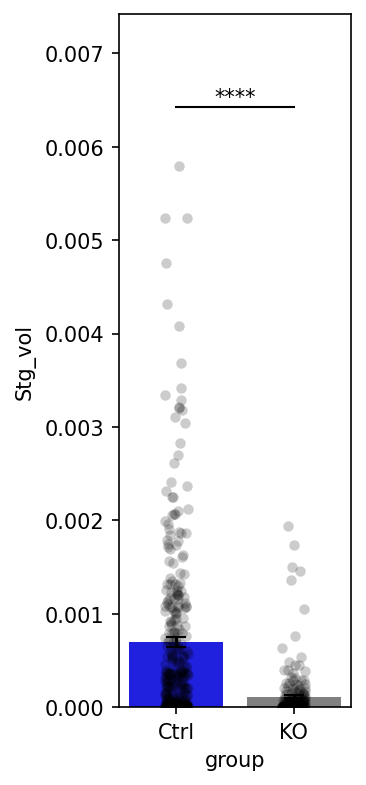

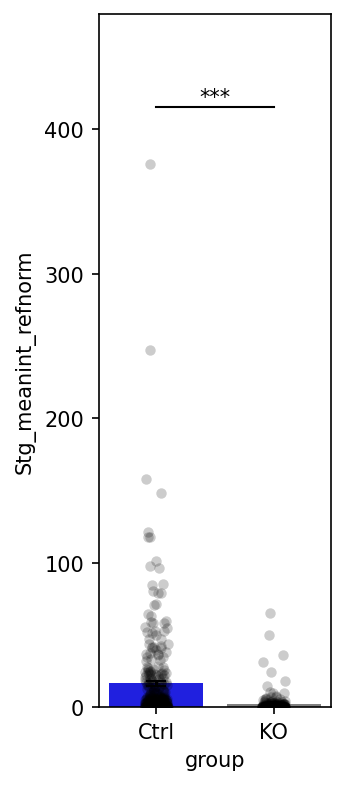

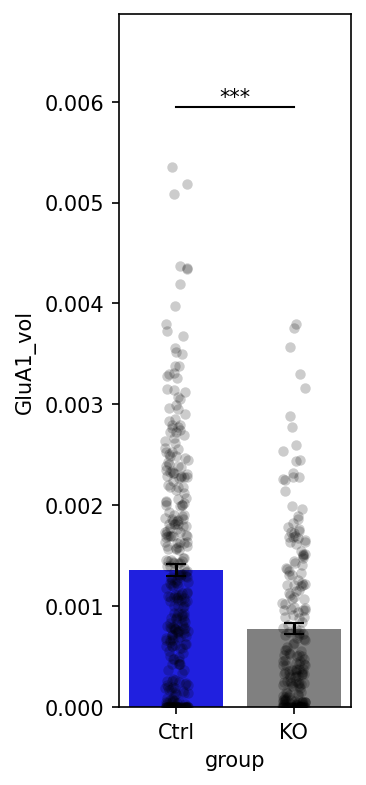

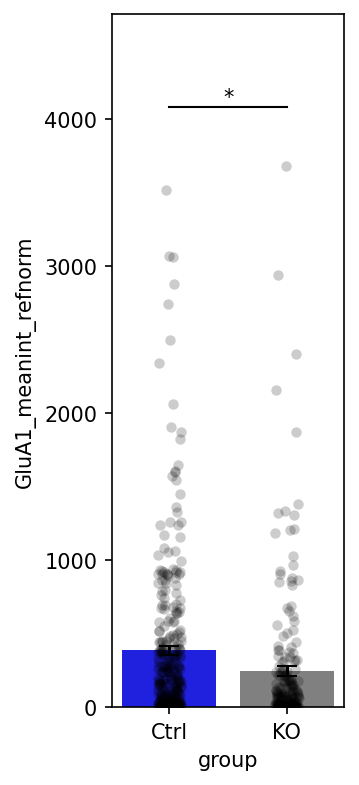

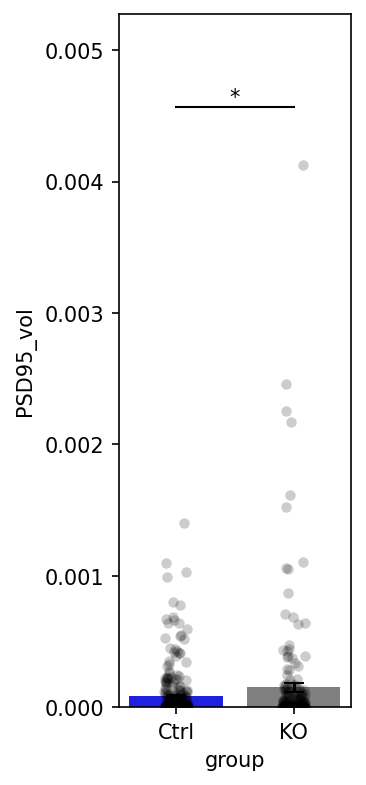

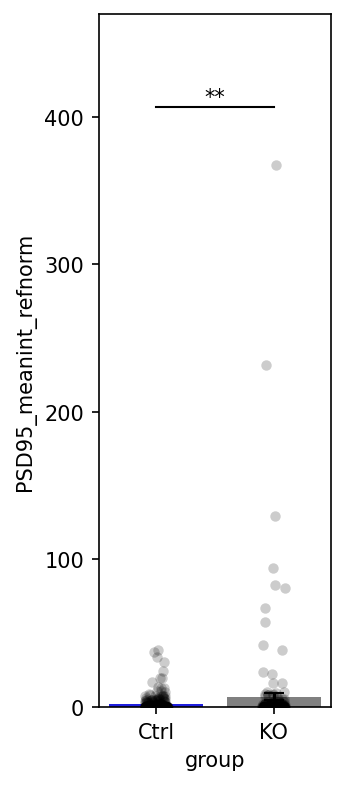

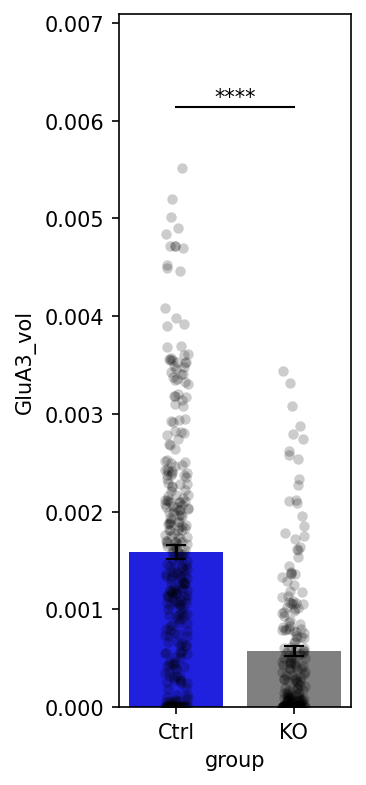

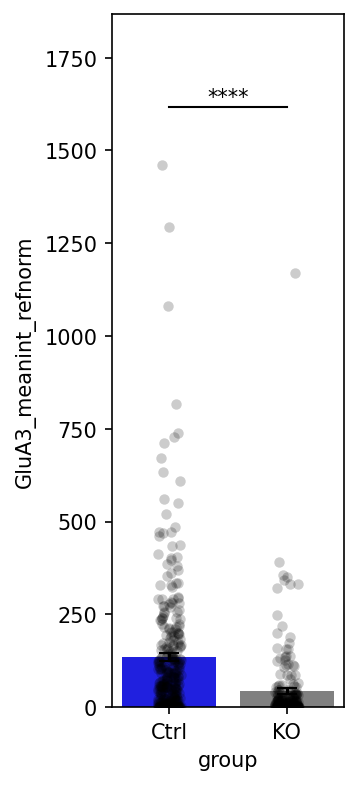

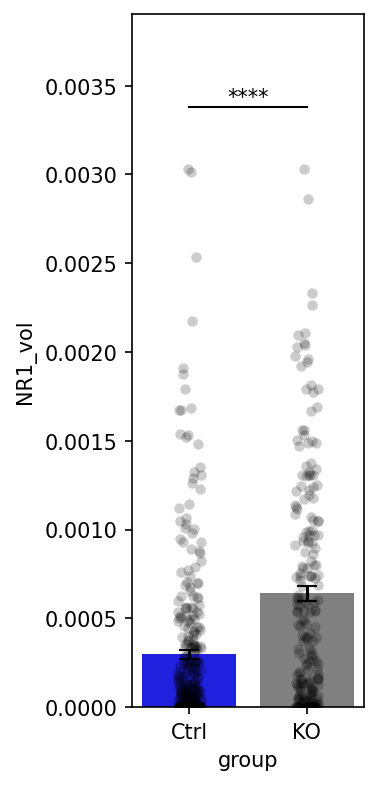

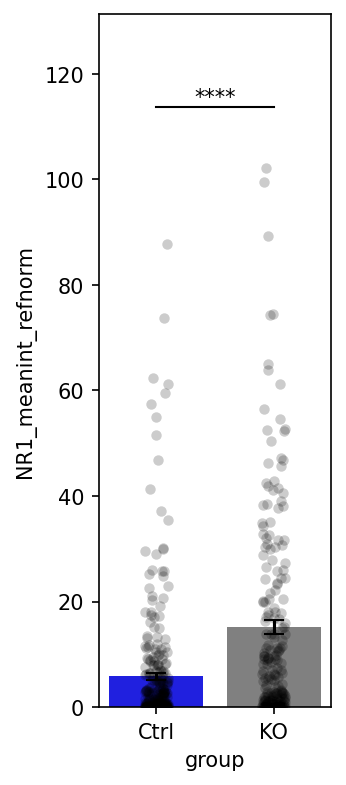

In [95]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your dataFrame with data is named 'data'
# and the data frame with significance information is named 'pvals_df'
# pvals_df should have an index matching the numerical variable names in 'data'

# Example dataFrames (uncomment and adjust according to your actual data)
# data = pd.read_csv('your_data.csv')
# pvals_df = pd.read_csv('your_significance_data.csv')

# Identify numerical columns in 'data'
numerical_columns = data.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')
    
# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for val in values:
        col = prot + '_' + val
        data_temp = data
        plt.figure(figsize=(2,6),dpi=150)
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/ctx_barplots_selected/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/ctx_barplots_selected/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()